In [62]:
from hssm.wfpt.simple_wrapper import create_hssm
import ssms.basic_simulators
import arviz as az

import pandas as pd
import numpy as np

## Simulating a dataset. 
-  dataset passed to the model should always include 'rt' and 'response'.
-  dataset should have a format of pandas dataframe.

In [63]:
# Simulate some data
v_true, a_true, z_true, t_true, theta_true = [0.5, 1.5, 0.5, 0.5, 0.3]
obs_angle = ssms.basic_simulators.simulator(
    [v_true, a_true, z_true, t_true, theta_true], model="angle", n_samples=1000
)
obs = np.column_stack([obs_angle["rts"][:, 0], obs_angle["choices"][:, 0]])
obs
dataset = pd.DataFrame(obs, columns=["rt", "response"])

## Using Base WFPT class (The analytical solution of the WFPT likelihood function)

In [58]:
trace_angle_ddm_base = create_hssm(data=dataset)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v, sv, a, z, t]
INFO:pymc:NUTS: [v, sv, a, z, t]
/Users/aomar7/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/aomar7/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 19 seconds.
INFO:pymc:Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 19 seconds.


array([[<AxesSubplot: title={'center': 'v'}>,
        <AxesSubplot: title={'center': 'v'}>],
       [<AxesSubplot: title={'center': 'sv'}>,
        <AxesSubplot: title={'center': 'sv'}>],
       [<AxesSubplot: title={'center': 'a'}>,
        <AxesSubplot: title={'center': 'a'}>],
       [<AxesSubplot: title={'center': 'z'}>,
        <AxesSubplot: title={'center': 'z'}>],
       [<AxesSubplot: title={'center': 't'}>,
        <AxesSubplot: title={'center': 't'}>]], dtype=object)

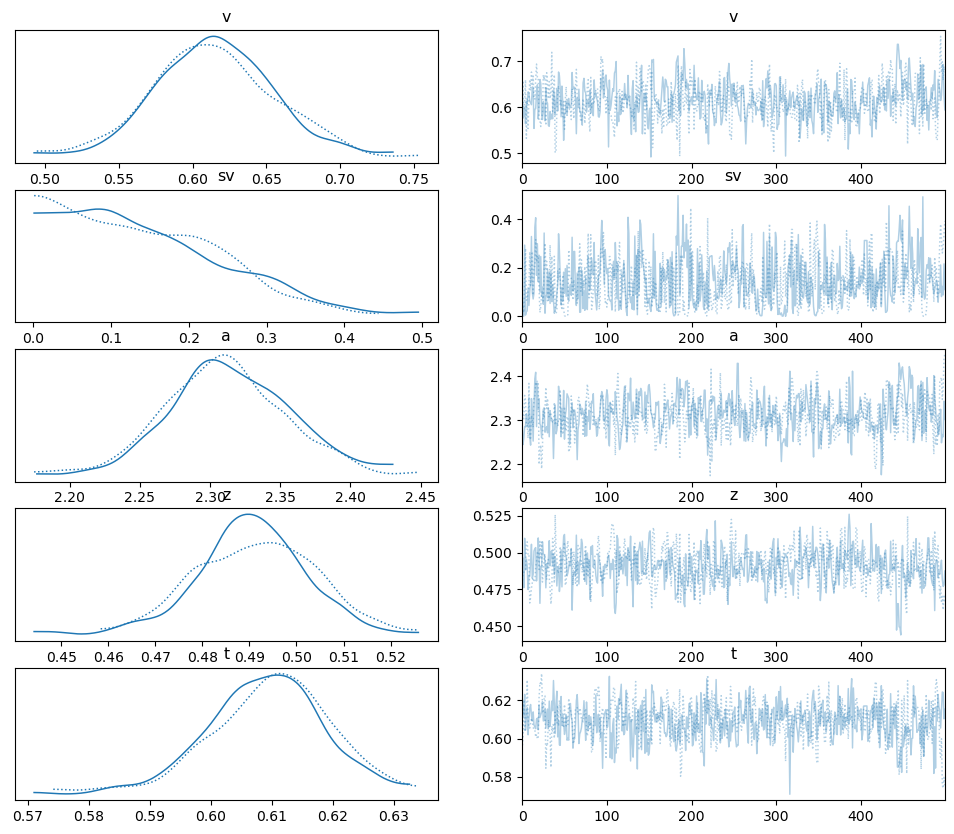

In [8]:
az.plot_trace(trace_angle_ddm_base)

### Customizing sample size 

In [67]:
trace_angle_ddm_base = create_hssm(data=dataset, draws=1000, tune=600)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v, sv, a, z, t]
INFO:pymc:NUTS: [v, sv, a, z, t]
/Users/aomar7/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/aomar7/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Sampling 2 chains for 600 tune and 1_000 draw iterations (1_200 + 2_000 draws total) took 21 seconds.
INFO:pymc:Sampling 2 chains for 600 tune and 1_000 draw iterations (1_200 + 2_000 draws total) took 21 seconds.


array([[<AxesSubplot: title={'center': 'v'}>,
        <AxesSubplot: title={'center': 'v'}>],
       [<AxesSubplot: title={'center': 'sv'}>,
        <AxesSubplot: title={'center': 'sv'}>],
       [<AxesSubplot: title={'center': 'a'}>,
        <AxesSubplot: title={'center': 'a'}>],
       [<AxesSubplot: title={'center': 'z'}>,
        <AxesSubplot: title={'center': 'z'}>],
       [<AxesSubplot: title={'center': 't'}>,
        <AxesSubplot: title={'center': 't'}>]], dtype=object)

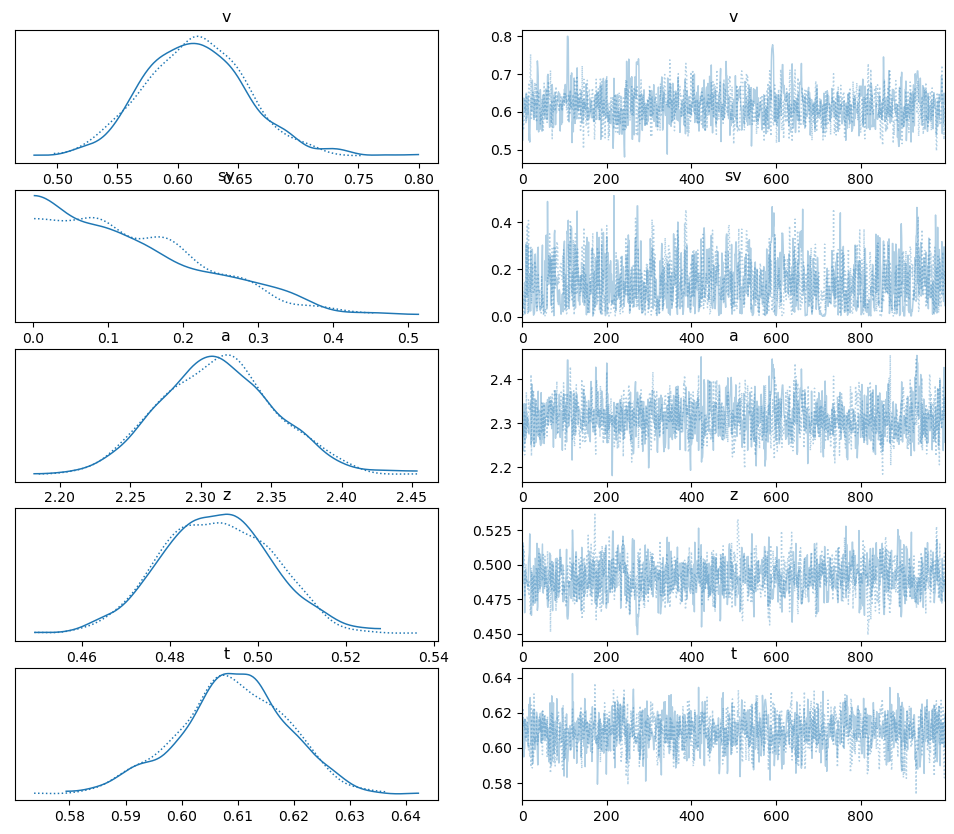

In [68]:
az.plot_trace(trace_angle_ddm_base)

## Using the lan factory functions for LAN related functionalities

### LAN using the JAX backend:

In [64]:
trace_ddm_nuts_jax_wrapped = create_hssm(
    data=dataset,
    model="lan",
)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v, sv, a, z, theta]
INFO:pymc:NUTS: [v, sv, a, z, theta]
/Users/aomar7/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/aomar7/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 52 seconds.
INFO:pymc:Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 52 seconds.


array([[<AxesSubplot: title={'center': 'v'}>,
        <AxesSubplot: title={'center': 'v'}>],
       [<AxesSubplot: title={'center': 'sv'}>,
        <AxesSubplot: title={'center': 'sv'}>],
       [<AxesSubplot: title={'center': 'a'}>,
        <AxesSubplot: title={'center': 'a'}>],
       [<AxesSubplot: title={'center': 'z'}>,
        <AxesSubplot: title={'center': 'z'}>],
       [<AxesSubplot: title={'center': 'theta'}>,
        <AxesSubplot: title={'center': 'theta'}>]], dtype=object)

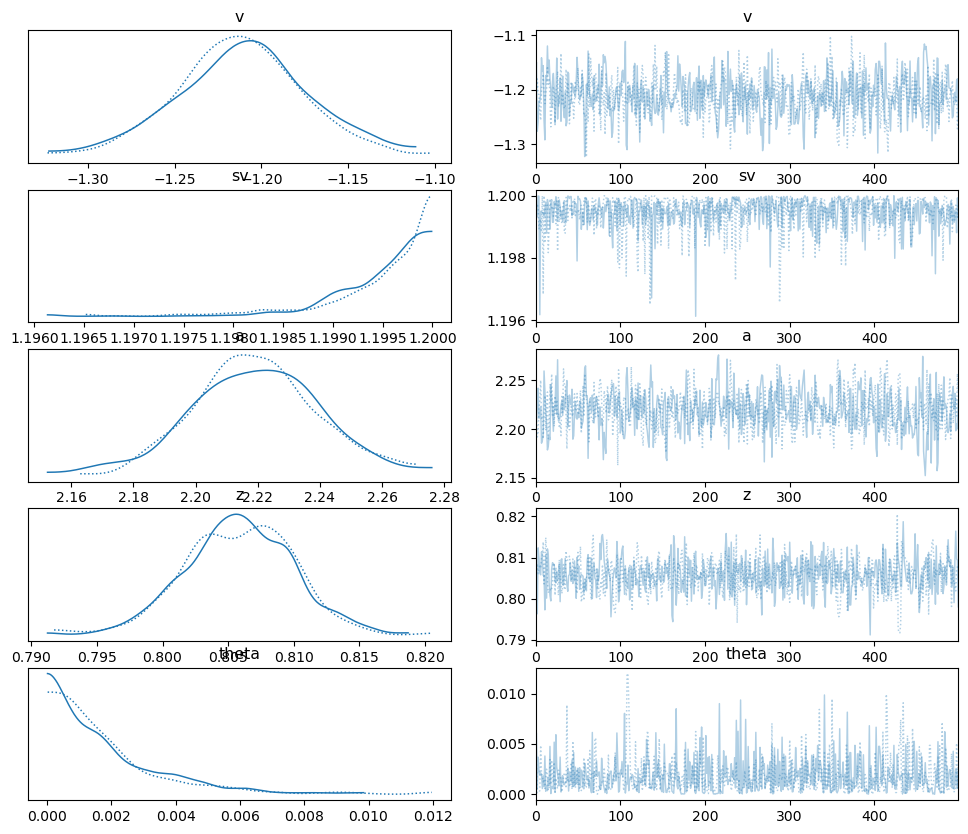

In [65]:
az.plot_trace(trace_ddm_nuts_jax_wrapped)

### Customizing sample size 

In [70]:
trace_ddm_nuts_jax_wrapped = create_hssm(
    data=dataset, model="lan", draws=1000, tune=600
)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v, sv, a, z, theta]
INFO:pymc:NUTS: [v, sv, a, z, theta]
/Users/aomar7/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/aomar7/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Sampling 2 chains for 600 tune and 1_000 draw iterations (1_200 + 2_000 draws total) took 60 seconds.
INFO:pymc:Sampling 2 chains for 600 tune and 1_000 draw iterations (1_200 + 2_000 draws total) took 60 seconds.


array([[<AxesSubplot: title={'center': 'v'}>,
        <AxesSubplot: title={'center': 'v'}>],
       [<AxesSubplot: title={'center': 'sv'}>,
        <AxesSubplot: title={'center': 'sv'}>],
       [<AxesSubplot: title={'center': 'a'}>,
        <AxesSubplot: title={'center': 'a'}>],
       [<AxesSubplot: title={'center': 'z'}>,
        <AxesSubplot: title={'center': 'z'}>],
       [<AxesSubplot: title={'center': 'theta'}>,
        <AxesSubplot: title={'center': 'theta'}>]], dtype=object)

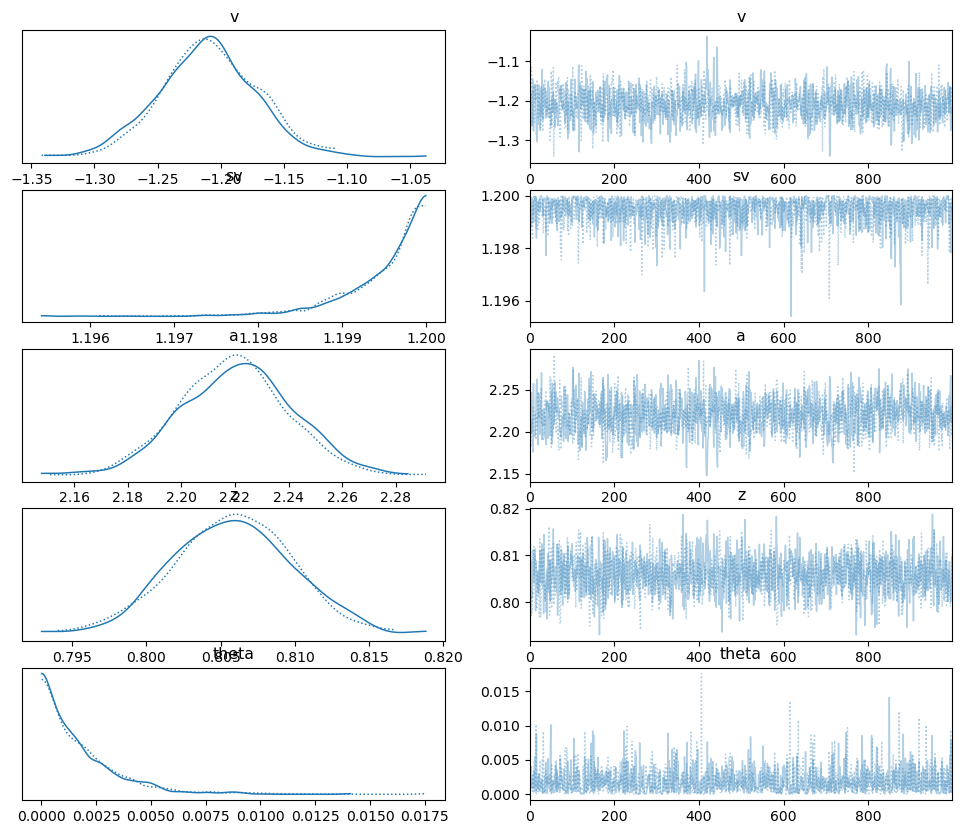

In [71]:
az.plot_trace(trace_ddm_nuts_jax_wrapped)